In [2]:
# import tables
import pandas as pd
from pandas import HDFStore
# import h5py
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import rasterio
from rasterio import features
from rasterio.plot import show
from pyproj import Transformer
import shapefile
from rasterstats import zonal_stats, point_query

In [10]:
# PIL.Image.MAX_IMAGE_PIXELS = None

In [11]:
# im = Image.open("./data/earth_observation_group/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.avg_rade9h.tif")
# im = im.resize((1000, 1000))
# im.show()

In [12]:
# im = pd.read_hdf("./data/NASA-NTL/VNP46A1.A2012019.h00v01.001.2019081205135.h5")
# f = HDFStore("/home/ankur/Ankur/CLS/thesis/data/NASA-NTL/VNP46A1.A2012019.h00v00.001.2019081193551.h5", mode='r')

In [13]:
# f = h5py.File("./data/NASA-NTL/VNP46A1.A2012019.h00v00.001.2019081193551.h5", 'r')
# print(f.keys())

In [14]:
# data = f["HDFEOS"]
# print(data.keys())

In [15]:
# t = data["GRIDS"]
# print(t.keys())

In [16]:
# p = t["VNP_Grid_DNB"]
# print(p.keys())

In [17]:
# for key, value in p["Data Fields"].items():
#     tmp = np.array(value)
#     print(key, np.min(tmp), np.max(tmp))

In [8]:
# value

In [93]:
fp = r'./data/earth_observation_group/SVDNB_npp_20210101-20210131_global_vcmslcfg_v10_c202102062300.avg_rade9h.tif'
img = rasterio.open(fp)

In [3]:
fp = r'../data/earth_observation_group/annual/2013/VNL_v2_npp_2013_global_vcmcfg_c202101211500.average.tif'
img = rasterio.open(fp)

In [4]:
img.height, img.width, img.crs

(33601, 86401, CRS.from_epsg(4326))

In [5]:
img.bounds

BoundingBox(left=-180.00208333335, bottom=-65.00208445335001, right=180.00208621335, top=75.00208333335)

In [6]:
def get_index_from_lat_long(lat, long):
    return img.index(long, lat)

In [12]:
img_array = img.read(1)
img_array.shape

In [13]:
transformer = rasterio.transform.AffineTransformer(img.transform)

In [26]:
transformer.xy((0,1),(0,1))

([-180.0, -179.9958333333], [75.0, 74.9958333333])

## Sensibility check(whether radiance values make sense)

In [94]:
buffer_pixels = 100
lat_long_dict = {
    "indian_ocean": (-11.78618, 67.47882),
    "equator": (0.0, 0.0),
    "amsterdam": (52.3676, 4.9041),
    "london": (51.5072, -0.1276),
    "new york": (40.7128, -74.006),
    "delhi": (28.7041, 77.1025),
    "abuja": (9.0765, 7.3986)
}

In [135]:
def get_coords_around_city(city_coords, buffer_pixels, img_transform):
    ys, xs = city_coords
    row, col = rasterio.transform.rowcol(img_transform, xs, ys)
    
    rows_to_find = np.arange(row-buffer_pixels, row+buffer_pixels)
    cols_to_find = np.arange(col-buffer_pixels, col+buffer_pixels)
    
    transformer = rasterio.transform.AffineTransformer(img_transform)
    return transformer.xy(rows_to_find, cols_to_find), (rows_to_find, cols_to_find)


def get_city_ntl_snapshot(city, buffer_pixels, lat_long_dict, img):
    (lons, lats), row_col = get_coords_around_city(lat_long_dict[city], buffer_pixels, img.transform)
    
    pts = []
    for lon in lons:
        for lat in lats:
            pts.append((lon, lat))
            
    new_img_array = []
    gen = rasterio.sample.sample_gen(img, pts)

    for _ in range(len(pts)):
        new_img_array.append(list(next(gen))[0])

    new_img_array = np.array(new_img_array)
    new_img_array = np.reshape(new_img_array, (buffer_pixels*2, buffer_pixels*2))
    new_img_array = np.flip(np.rot90(new_img_array, k=3), axis=1)
    
    return new_img_array
    

In [139]:
cities = ["delhi", "london", "amsterdam", "new york", "abuja"]

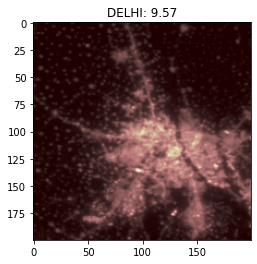

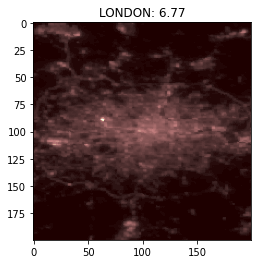

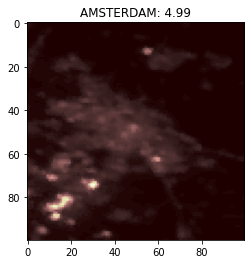

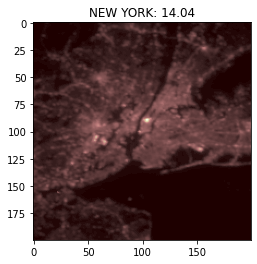

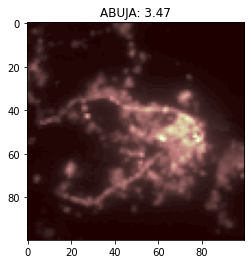

In [141]:
for city in cities:
    if city in ["abuja", "amsterdam"]:
        buffer_pixels = 50
    else:
        buffer_pixels = 100
    new_img_array = get_city_ntl_snapshot(city, buffer_pixels, lat_long_dict, img)
    avg_radiance_val = round(np.average(new_img_array), 2)
    plt.title(city.upper() + ": " + str(avg_radiance_val))
    plt.imshow(new_img_array, cmap='pink')
    plt.savefig("../data/pictures/ntl_{}_viirs.png".format(city), bbox_inches='tight')
    plt.show()

In [24]:
# radiance_dict = {}
# for key, value in lat_long_dict.items():
#     xs = value[1]
#     ys = value[0]
#     row, col = rasterio.transform.rowcol(img.transform, xs, ys)

#     if key == "amsterdam":
#         tmp = img_array[row-50: row+50, 
#                     col-50: col+50]
#     else:
#         tmp = img_array[row-buffer_pixels: row+buffer_pixels, 
#                         col-buffer_pixels: col+buffer_pixels]

#     radiance_dict[key] = tmp

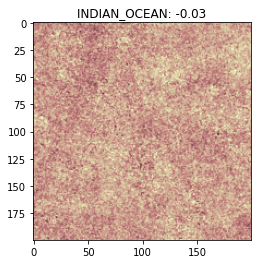

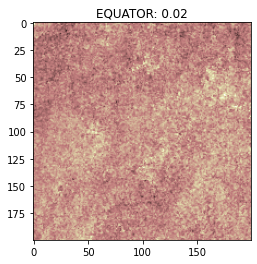

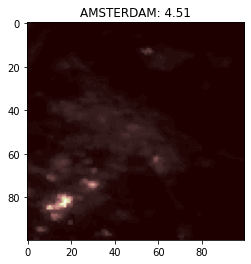

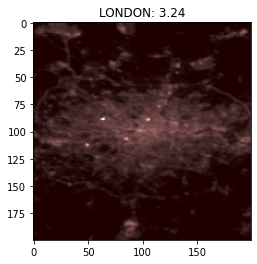

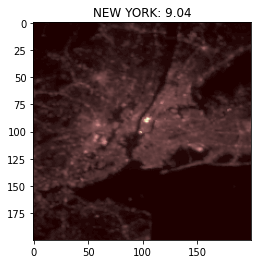

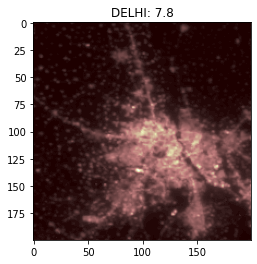

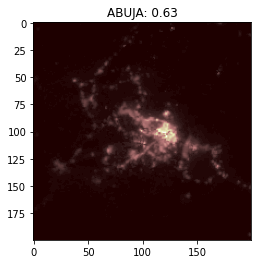

In [25]:
for key, value in radiance_dict.items():
    avg_radiance_val = round(np.average(value), 2)
    plt.imshow(value, cmap='pink')
    plt.title(key.upper() + ": " + str(avg_radiance_val))
    plt.show()

In [152]:
## ToDo:
# 1. Algorithm for summing radiance value for a country -- DONE
# 2. Algorithm for summing radiance value for a city -- DONE
# 3. Implement the algorithm to disagregate the GDP -- DONE
# 4. Choose two countries and see if developing countries give good NTL data -- DONE

In [27]:
shape = shapefile.Reader("./data/country_geometry/all_country/ne_10m_admin_0_countries.shp")
feature = shape.shapeRecords()[0]
first = feature.shape.__geo_interface__ 

In [28]:
coords = first["coordinates"]

In [29]:
left, bottom, right, top = features.bounds(feature)

In [30]:
left, bottom, right, top

(95.01270592500003, -10.922621351999908, 140.97762699400005, 5.910101630000042)

In [31]:
stats = zonal_stats('./data/country_geometry/all_country/ne_10m_admin_0_countries.shp', 
                    './data/earth_observation_group/annual/2012/VNL_v2_npp_201204-201212_global_vcmcfg_c202101211500.average.tif', 
                   stats='sum')

/home/ankur/miniconda3/lib/python3.9/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [32]:
stats

[{'sum': 851293.5625},
 {'sum': 588174.875},
 {'sum': 795862.375},
 {'sum': 201656.40625},
 {'sum': 388356.5625},
 {'sum': 3914452.0},
 {'sum': 2165.19287109375},
 {'sum': 57273.7890625},
 {'sum': 7565244.5},
 {'sum': 15152584.0},
 {'sum': 695988.0},
 {'sum': 149169.28125},
 {'sum': 163572.390625},
 {'sum': 99070.0859375},
 {'sum': 207148.265625},
 {'sum': 47190.7578125},
 {'sum': 107864.3359375},
 {'sum': 50775.5},
 {'sum': 246800.1875},
 {'sum': 630618.125},
 {'sum': 24956.87109375},
 {'sum': 1449653.0},
 {'sum': -5516.32275390625},
 {'sum': -11296.6708984375},
 {'sum': 1575051.375},
 {'sum': 26226.5078125},
 {'sum': 1010255.5625},
 {'sum': 46243.74609375},
 {'sum': 122401.640625},
 {'sum': 35403.2421875},
 {'sum': 161884.375},
 {'sum': 460330.75},
 {'sum': 23184.02734375},
 {'sum': 416141.71875},
 {'sum': 197971.546875},
 {'sum': 206251.125},
 {'sum': 2097540.25},
 {'sum': 1771.5660400390625},
 {'sum': 1144.32421875},
 {'sum': 1017921.25},
 {'sum': 562843.6875},
 {'sum': 844396.8125

In [54]:
for val in shape.iterShapeRecords():
    print(val.shape.points)
    break

[(117.70360790395524, 4.163414542001791), (117.70360790400008, 4.163414542000055), (117.73807146200011, 4.157241908000032), (117.78357224700005, 4.157241908000032), (117.85255730900013, 4.157241908000032), (117.9070390276059, 4.156683015004099), (117.91211998800009, 4.144924221000053), (117.91822350400003, 4.100043036000045), (117.93482506600003, 4.0598819030000755), (117.90137780000009, 4.0366885440000715), (117.88705488400001, 4.031927802000041), (117.87256920700008, 4.03156159100007), (117.83855228000004, 4.040187893000052), (117.81910241000003, 4.06867096600007), (117.76270592500009, 4.100734768000052), (117.73943118600005, 4.132310289000088), (117.70360790395524, 4.163414542001791), (124.45053144600001, -9.180189710999912), (124.46583092500009, -9.17937590899993), (124.51783287900003, -9.17782968499995), (124.56324303500003, -9.17083098799992), (124.60434004000001, -9.15634530999995), (124.66797936300009, -9.11305103999996), (124.67115319100003, -9.10751718499995), (124.6731876960